# Notebook to test and illustrate FAST algorithm

In [1]:
%load_ext autoreload
%autoreload 2

### Tests on single image

In [2]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm

from lib import fast
from lib import opticalFlow

### global params

In [3]:
TRAIN_FRAMES_FOR_KP_DETECTION = 10

START_IDX = 60
if START_IDX - TRAIN_FRAMES_FOR_KP_DETECTION <= 0:
    START_IDX = TRAIN_FRAMES_FOR_KP_DETECTION + 1
END_IDX = 100

nb_keypoints = 50

skip = 1

START_IDX_KP = START_IDX - TRAIN_FRAMES_FOR_KP_DETECTION
END_IDX_KP = START_IDX - 1

cols = 4
rows = 3

print(f"Train kp from {START_IDX_KP} to {END_IDX_KP}")

Train kp from 50 to 59


### Good Feature to Track params

In [4]:
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = nb_keypoints,
                       qualityLevel = 0.3,
                       minDistance = 20,
                       blockSize = 7 )
# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

### Get first frame

In [5]:
# Take first frame and find corners in it
cap = cv2.VideoCapture("imgs/person_dog.mp4")
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

### Get KP

Number of final keypoints FAST: 64
Number of final keypoints GFTT: 50


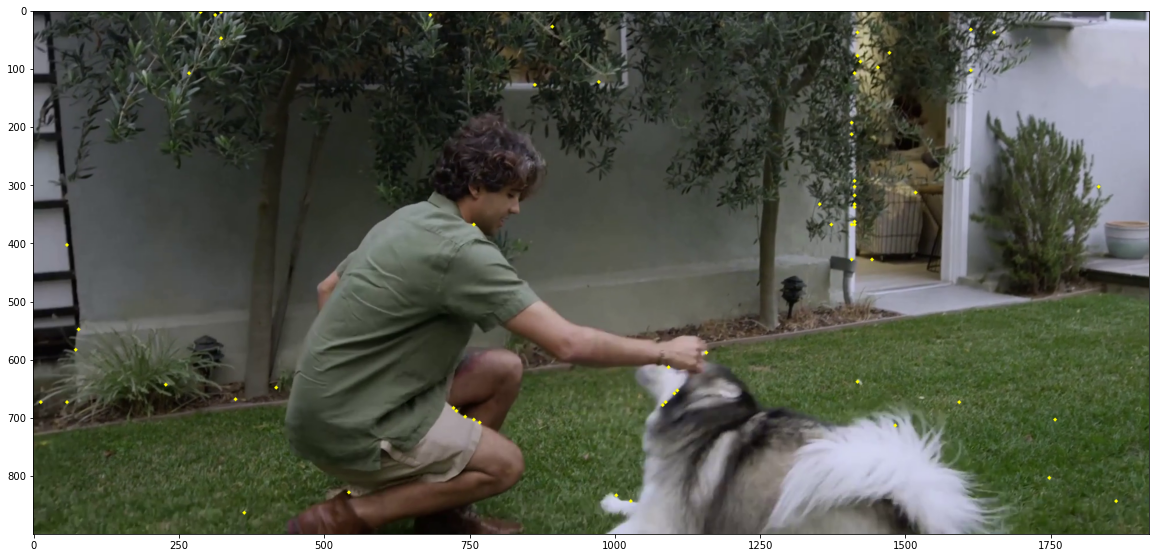

In [6]:
IDX_KP = 0

cap = cv2.VideoCapture("imgs/person_dog.mp4")
ret, frame = cap.read()

while ret:
    if START_IDX_KP <= IDX_KP < END_IDX_KP:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        keypoints_FAST = fast.detect_with_adaptive_threshold_and_grid(
            gray, nb_keypoints, N=12, step=5, epsilon=nb_keypoints*0.1,
            percentage=0.15, init_thresholds=None, rows=rows, cols=cols)

        keypoints_GFTT = cv2.goodFeaturesToTrack(gray, mask = None, **feature_params)
    if IDX_KP >= END_IDX_KP - 1:
        break
    ret, frame = cap.read()
    IDX_KP += 1
    print(f'IDX={IDX_KP}', end='\r')

img_with_kp = fast.draw(frame, keypoints_FAST)

fig=plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(img_with_kp, cv2.COLOR_BGR2RGB))

# convert output to goodFeaturesToTrack shape
keypoints_FAST = np.flip(np.expand_dims(keypoints_FAST, axis=1).astype(np.float32))

print(f"Number of final keypoints FAST: {keypoints_FAST.shape[0]}")
print(f"Number of final keypoints GFTT: {keypoints_GFTT.shape[0]}")

In [7]:
# Create some random colors
color = np.random.randint(0, 255, (max(keypoints_GFTT.shape[0], keypoints_FAST.shape[0]), 3))

# Test params

In [27]:
TEST_HOMEMADE_KP_DETECTOR = True
TEST_HOMEMADE_KP_TRACKER = False
TEST_WITH_FLOW_IMG = True

detector = 'opencvDetector'
tracker = 'opencvTracker'
flow_img_suffix = ''

if TEST_HOMEMADE_KP_DETECTOR:
    kp_to_use = keypoints_FAST.copy()
    detector = 'homemadeDetector'
else:
    kp_to_use = keypoints_GFTT.copy()
if TEST_HOMEMADE_KP_TRACKER:
    tracker = 'homemadeTracker'
if TEST_WITH_FLOW_IMG:
    flow_img_suffix = '_with_flow'

result_gif = f'imgs/person_dog_{detector}_{tracker}{flow_img_suffix}.gif'

# run detector and tracker

In [29]:
def flow_to_rgb(flow, mask):
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    mask[..., 0] = angle * 180 / np.pi / 2
    mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    return mask

In [30]:
cap = cv2.VideoCapture("imgs/person_dog.mp4")
IDX = 0
imgs = []

# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)
flow_imgs = []
flow_imgs2 = []

while(cap.isOpened()):
    ret, frame = cap.read()
    if not ret:
        break
    if IDX % skip != 0:
        IDX += 1
        continue
    if START_IDX < IDX < END_IDX:
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # calculate optical flow
        if TEST_HOMEMADE_KP_TRACKER:
            p1, st, flow = calcOpticalFlow(old_gray, frame_gray, kp_to_use)
            if TEST_WITH_FLOW_IMG:
                mask = flow_to_rgb(flow, mask)
        else:
            p1, st, _ = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, kp_to_use, None, **lk_params)
            if TEST_WITH_FLOW_IMG:
                flow = cv2.calcOpticalFlowFarneback(old_gray, frame_gray, None,
                                                    0.5, 3, 15, 3, 5, 1.2, 0)
                mask = flow_to_rgb(flow, mask)
        #p1, st = optical_flow(old_gray, frame_gray, kp_to_use, window_size = 16, tau=1e-2)
        # Select good points
        if p1 is not None:
            good_new = p1[st==1]
            good_old = kp_to_use[st==1]
        # draw the tracks
        for i,(new,old) in enumerate(zip(good_new, good_old)):
            a,b = new.ravel()
            c,d = old.ravel()
            mask = cv2.line(mask, (int(a),int(b)),(int(c),int(d)), color[i].tolist(), 2)
            frame = cv2.circle(frame,(int(a),int(b)),5,color[i].tolist(),-1)
        img = cv2.add(frame, mask)
        # Now update the previous frame and previous points
        old_gray = frame_gray.copy()
        kp_to_use = good_new.reshape(-1,1,2)
        imgs.append(Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))
    elif IDX >= END_IDX:
        break
    IDX += 1
    print(f'IDX={IDX}', end='\r')

imgs[0].save(result_gif, format='GIF',
             append_images=imgs[1:],
             save_all=True, loop=0)
    
cap.release()
cv2.destroyAllWindows()